In [1]:
! pip install import-ipynb

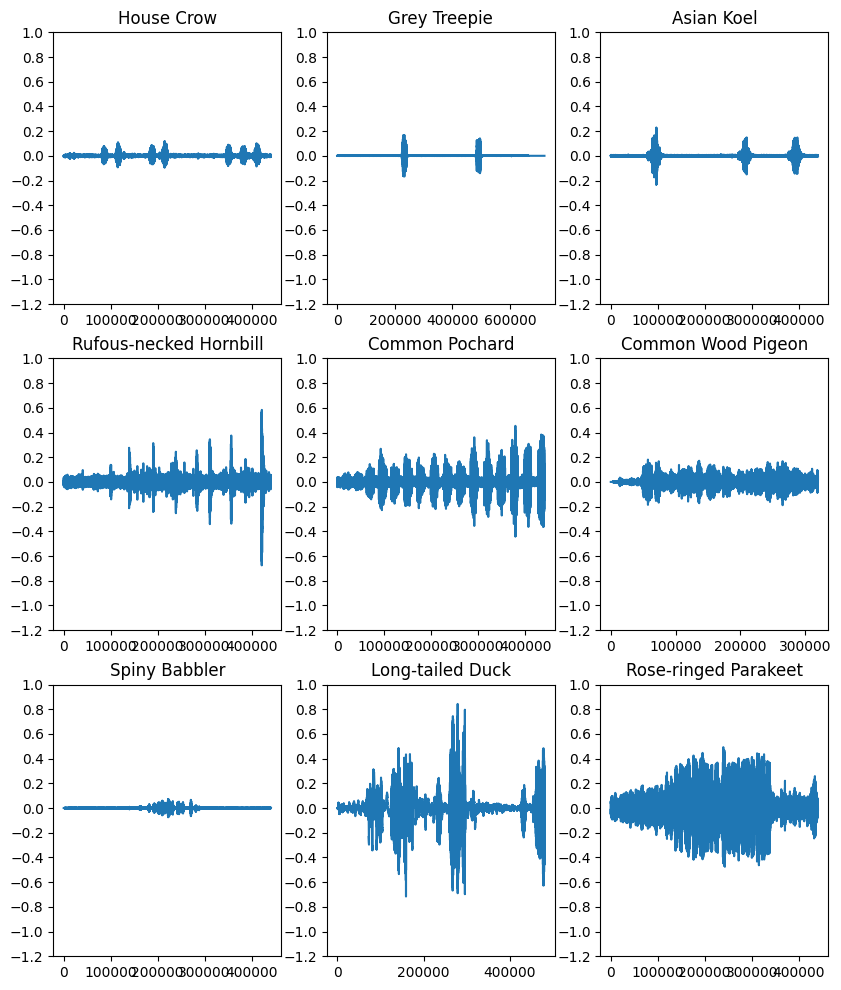

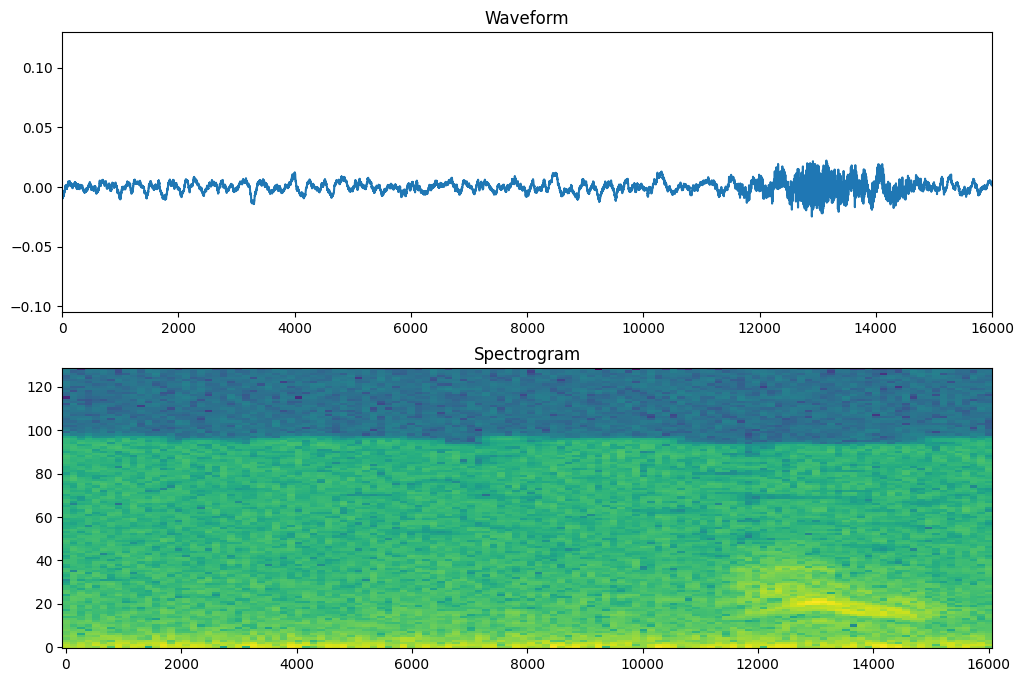

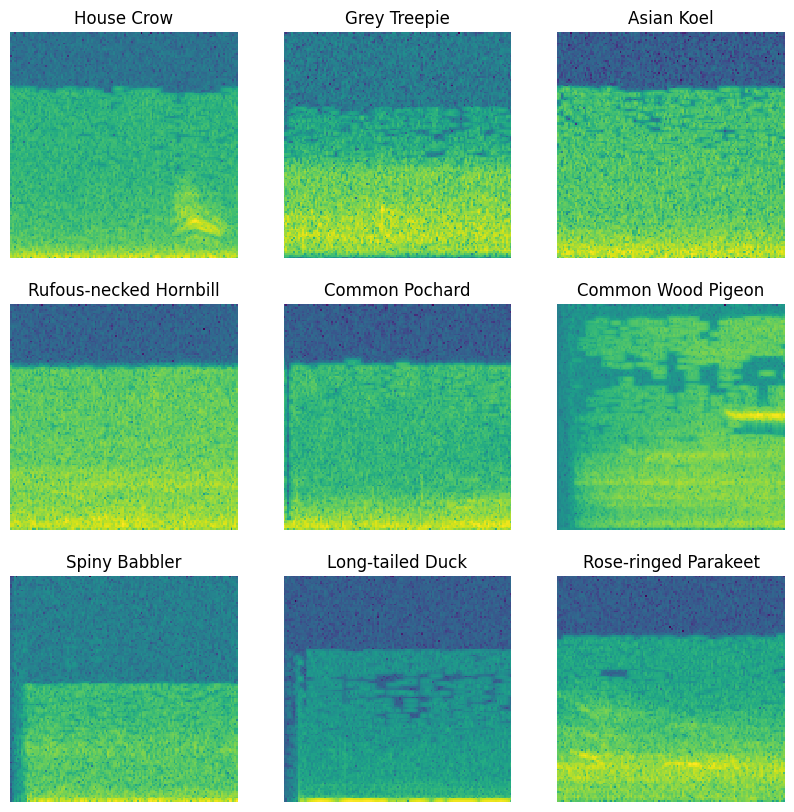

In [2]:
%run extractAudio.ipynb

In [3]:
from tensorflow import keras
from keras import layers
from keras import models

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential(
    [
        layers.Input(shape=input_shape),
        # Downsample the input.
        layers.Resizing(32, 32),
        # Normalize.
        norm_layer,
        # Plus de conv, + de max pulling, + de dense, + grabd nm
        layers.Conv2D(32, 3, activation="relu"),
        layers.Conv2D(64, 3, activation="relu"),
        layers.MaxPooling2D(),
        layers.Dropout(0.25),
        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(num_labels),
    ]
)

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizati  (None, 32, 32, 1)         3         
 on)                                                             
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)       

In [4]:
model.compile(
    optimizer           = tf.keras.optimizers.Adam(),
    loss                = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics             = ["accuracy"],
)

In [5]:
EPOCHS = 10
history = model.fit(
    train_ds,
    validation_data     = val_ds,
    epochs              = EPOCHS,
    callbacks           = tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10


82/82 [==============================] - 129s 1s/step - loss: 3.3361 - accuracy: 0.0957 - val_loss: 3.0933 - val_accuracy: 0.1487
Epoch 2/10
82/82 [==============================] - 14s 176ms/step - loss: 3.0952 - accuracy: 0.1442 - val_loss: 2.9348 - val_accuracy: 0.1815
Epoch 3/10
82/82 [==============================] - 15s 178ms/step - loss: 2.9310 - accuracy: 0.1787 - val_loss: 2.8326 - val_accuracy: 0.2379
Epoch 4/10
82/82 [==============================] - 15s 178ms/step - loss: 2.7949 - accuracy: 0.2224 - val_loss: 2.7193 - val_accuracy: 0.2582
Epoch 5/10
82/82 [==============================] - 15s 178ms/step - loss: 2.6737 - accuracy: 0.2567 - val_loss: 2.6798 - val_accuracy: 0.2739
Epoch 6/10
82/82 [==============================] - 14s 166ms/step - loss: 2.5743 - accuracy: 0.2747 - val_loss: 2.6301 - val_accuracy: 0.2864
Epoch 7/10
82/82 [==============================] - 14s 166ms/step - loss: 2.4815 - accuracy: 0.2954 - val_loss: 2.6322 - val_accuracy: 0.2864

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizati  (None, 32, 32, 1)         3         
 on)                                                             
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0

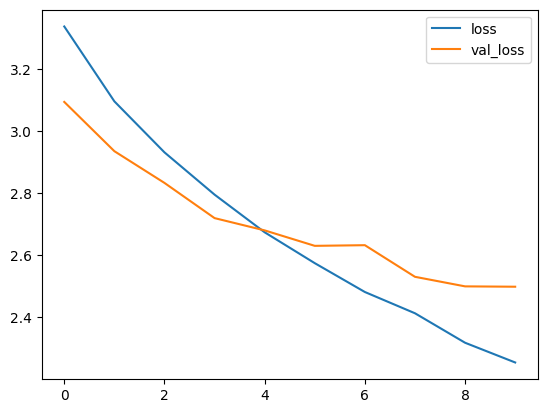

In [6]:
metrics = history.history
plt.plot(history.epoch, metrics["loss"], metrics["val_loss"])
plt.legend(["loss", "val_loss"])
plt.show()

In [7]:
test_audio = []
test_labels = []

for audio, label in test_ds:
    test_audio.append(audio.numpy())
    test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [8]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f"Test set accuracy: {test_acc:.0%}")

22/22 [==============================] - 2s 27ms/step
Test set accuracy: 36%


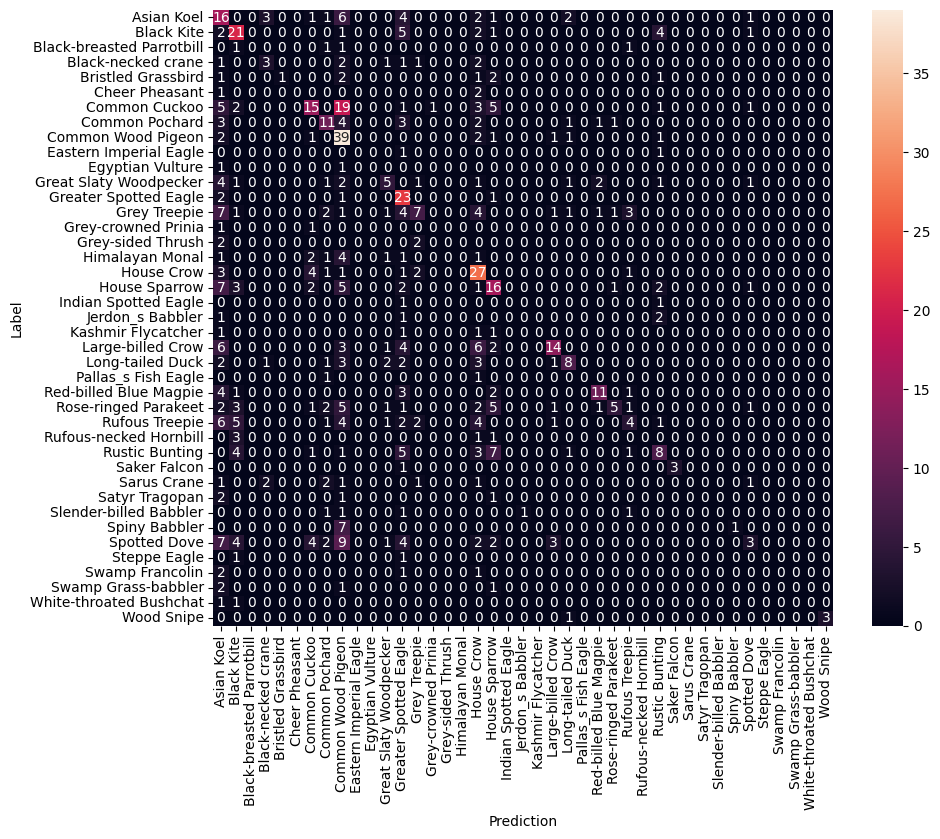

In [9]:
import seaborn as sns

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(
    confusion_mtx, xticklabels=birds, yticklabels=birds, annot=True, fmt="g"
)
plt.xlabel("Prediction")
plt.ylabel("Label")
plt.show()